In [4]:
from metrics.function_error import SquaredError
from models.linear import LeastSquaresModel
from models.zero_model import ZeroModel
from function_classes.linear import LinearRegression

from torch.distributions.normal import Normal
import torch

from torch import nn


from torch import normal

In [5]:
m = Normal(torch.zeros((4, 100, 10)), torch.ones((4, 100 ,10))) #batch size, sequence_length, x_dim

error=SquaredError(function_class=LinearRegression(m))

evals=error.evaluate([LeastSquaresModel(), ZeroModel()])

print(evals[0].keys())

print(evals[1])

ValueError: too many values to unpack (expected 2)

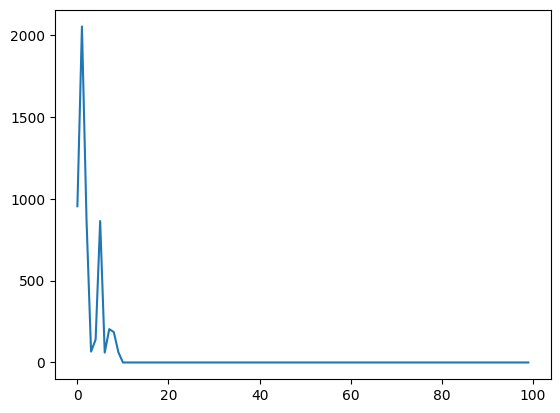

In [7]:
import matplotlib.pyplot as plt

plt.plot(evals[0]['accuracy_OLS_driver=None'])